In [9]:
from __future__ import print_function, division
import time
import csv

from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from six import iteritems

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM
import nilmtk.utils
from nilmtk.dataset_converters.ukdale.convert_ukdale import convert_ukdale

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from sklearn import preprocessing

%matplotlib inline
rcParams['figure.figsize'] = (13, 6)

In [10]:
def train_and_predict_selected_appliances(input_meter,test_elec,test,appliances_chunk):
    classifiers = {'FHMM':FHMM()}
    predictions = {}
    sample_period = 120
    for clf_name, clf in classifiers.items():
        start = time.time()
        clf.train(input_meter, sample_period=sample_period)
        end = time.time()
        print("Runtime =", end-start, "seconds.")
        gt, predictions[clf_name] = predict_selected_appliances(clf, test_elec, sample_period, test.metadata['timezone'],appliances_chunk)
    return gt, predictions
        
def predict_selected_appliances(clf, test_elec, sample_period, timezone,appliances_chunk):
    pred = {}
    gt= {}
    for i, chunk in enumerate(test_elec.mains().load(physical_quantity = 'power', ac_type = 'active', sample_period=sample_period)):
        chunk_drop_na = chunk.dropna()
        pred[i] = clf.disaggregate_chunk(chunk_drop_na)
        gt[i]={}

        for meter in test_elec.submeters().select_using_appliances(type=appliances_chunk).meters:
            # Only use the meters that we trained on (this saves time!)    
            gt[i][meter] = next(meter.load(physical_quantity = 'power', ac_type = 'active', sample_period=sample_period))
        gt[i] = pd.DataFrame({k:v.squeeze() for k,v in iteritems(gt[i]) if len(v)}, index=next(iter(gt[i].values())).index).dropna()
        
    # If everything can fit in memory
    gt_overall = pd.concat(gt)
    gt_overall.index = gt_overall.index.droplevel()
    pred_overall = pd.concat(pred)
    pred_overall.index = pred_overall.index.droplevel()

    # Having the same order of columns
    gt_overall = gt_overall[pred_overall.columns]
    
    #Intersection of index
    gt_index_utc = gt_overall.index.tz_convert("UTC")
    pred_index_utc = pred_overall.index.tz_convert("UTC")
    common_index_utc = gt_index_utc.intersection(pred_index_utc)
    
    common_index_local = common_index_utc.tz_convert(timezone)
    gt_overall = gt_overall.loc[common_index_local]
    pred_overall = pred_overall.loc[common_index_local]
    appliance_labels = [m for m in gt_overall.columns.values]
    gt_overall.columns = appliance_labels
    pred_overall.columns = appliance_labels
    return gt_overall, pred_overall

def predict(clf, test_elec, sample_period, timezone):
    pred = {}
    gt= {}
    
    # "ac_type" varies according to the dataset used. 
    # Make sure to use the correct ac_type before using the default parameters in this code.    
    for i, chunk in enumerate(test_elec.mains().load(physical_quantity = 'power', ac_type = 'active', sample_period=sample_period)):
        chunk_drop_na = chunk.dropna()
        pred[i] = clf.disaggregate_chunk(chunk_drop_na)
        gt[i]={}

        for meter in test_elec.submeters().meters:
            # Only use the meters that we trained on (this saves time!)    
            gt[i][meter] = next(meter.load(physical_quantity = 'power', ac_type = 'active', sample_period=sample_period))
        gt[i] = pd.DataFrame({k:v.squeeze() for k,v in iteritems(gt[i]) if len(v)}, index=next(iter(gt[i].values())).index).dropna()
        
    # If everything can fit in memory
    gt_overall = pd.concat(gt)
    gt_overall.index = gt_overall.index.droplevel()
    pred_overall = pd.concat(pred)
    pred_overall.index = pred_overall.index.droplevel()

    # Having the same order of columns
    gt_overall = gt_overall[pred_overall.columns]
    
    #Intersection of index
    gt_index_utc = gt_overall.index.tz_convert("UTC")
    pred_index_utc = pred_overall.index.tz_convert("UTC")
    common_index_utc = gt_index_utc.intersection(pred_index_utc)
    
    common_index_local = common_index_utc.tz_convert(timezone)
    gt_overall = gt_overall.loc[common_index_local]
    pred_overall = pred_overall.loc[common_index_local]
    appliance_labels = [m for m in gt_overall.columns.values]
    gt_overall.columns = appliance_labels
    pred_overall.columns = appliance_labels
    return gt_overall, pred_overall

def convert_to_on_off(curr):
    if float(curr)==0.0: 
        return 0.0 
    elif float(curr)>0: 
        return 1.0
    
def convert_to_on_off_gt(curr, mean_value):
    if float(curr)<float(mean_value): 
        return 0.0 
    elif float(curr)>=float(mean_value): 
        return 1.0
    
def df_column_uniquify(df):
    df_columns = df.columns
    new_columns = []
    for item in df_columns:
        counter = 0
        newitem = item
        while newitem in new_columns:
            counter += 1
            newitem = "{}_{}".format(item, counter)
        new_columns.append(newitem)
    df.columns = new_columns
    return df


In [11]:
ukdale_dataset_path = '../dataset/ukdale'
ukdale_dataset_h5_path = 'ukdale.h5'
building_no = 2

#Change the list of appliances when running this code for another house
list_of_appliances=["dish washer","fridge","laptop computer","computer monitor","active speaker","fridge","microwave","computer","broadband router","external hard disk","fridge","kettle","rice cooker","toaster","games console","fridge","modem","running machine","washing machine","cooker"]

co_predictions_csv_path = "./Predictions/Building_" + str(building_no) + "/predictions_CO.csv"
fhmm_predictions_csv_path = "./Predictions/Building_" + str(building_no) + "/predictions_FHMM.csv"
gt_csv_path = "./Predictions/Building_" + str(building_no) + "/ground_truth.csv"

modified_co_predictions_csv_path = "./Predictions/Building_" + str(building_no) + "/modified_predictions_CO.csv"
modified_fhmm_predictions_csv_path = "./Predictions/Building_" + str(building_no) + "/modified_predictions_FHMM.csv"
modified_gt_csv_path = "./Predictions/Building_" + str(building_no) + "/modified_ground_truth.csv"


### Convert the UK-DALE dataset to NILMTK HDF5 format

> If you encounter a "No object named xxxxx" error while running this code, download the ukdale.h5.tgz file from https://data.ukedc.rl.ac.uk/browse/edc/efficiency/residential/EnergyConsumption/Domestic/UK-DALE-2015/UK-DALE-disaggregated 


In [2]:
convert_ukdale(ukdale_dataset_path, ukdale_dataset_h5_path)

Done converting YAML metadata to HDF5!
Done converting YAML metadata to HDF5!
Loading 1-second data for /building1/elec/meter54 ...
Loading 1-second data for /building2/elec/meter20 ...
Loading 1-second data for /building5/elec/meter26 ...
Done converting UK-DALE to HDF5!


### Create train and test data

In [12]:
train = DataSet(ukdale_dataset_h5_path)
test = DataSet(ukdale_dataset_h5_path)
print('Loaded', len(train.buildings), 'buildings')

Loaded 5 buildings


In [13]:
train_data = train.buildings[building_no].elec
test_data = test.buildings[building_no].elec
mains = train_data.mains()
submeters = train_data.submeters()
elec2 = train.buildings[building_no].elec

### Train using CO

In [14]:
classifiers = {'CO':CombinatorialOptimisation()}
predictions = {}
gt = {}
sample_period = 120
for clf_name, clf in classifiers.items():
    start = time.time()
    clf.train(submeters, sample_period=sample_period)
    end = time.time()
    print("CO predictions Runtime =", end-start, "seconds.")
    gt_co, predictions_co = predict(clf, test_data, sample_period, train.metadata['timezone'])

Training model for submeter 'ElecMeter(instance=2, building=2, dataset='UK-DALE', appliances=[Appliance(type='laptop computer', instance=1)])'
Training model for submeter 'ElecMeter(instance=3, building=2, dataset='UK-DALE', appliances=[Appliance(type='computer monitor', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=2, dataset='UK-DALE', appliances=[Appliance(type='active speaker', instance=1)])'
Training model for submeter 'ElecMeter(instance=5, building=2, dataset='UK-DALE', appliances=[Appliance(type='computer', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=2, dataset='UK-DALE', appliances=[Appliance(type='broadband router', instance=1)])'
Training model for submeter 'ElecMeter(instance=7, building=2, dataset='UK-DALE', appliances=[Appliance(type='external hard disk', instance=1)])'
Training model for submeter 'ElecMeter(instance=8, building=2, dataset='UK-DALE', appliances=[Appliance(type='kettle', instance=1)])'
Training mo

### Training using FHMM 

In [15]:
pred=[]
ground_truth= []
for i in range(0, len(list_of_appliances), 5):
    train_elec = []
    appliances_chunk= list_of_appliances[i:i+5]
    train_elec.append(elec2.submeters().select_using_appliances(type=appliances_chunk))
    train = []
    for item in train_elec:
        for meter in item.meters:
            train.append(meter)
    
    input_meter = MeterGroup(train)
    gt_fhmm, predictions_fhmm=train_and_predict_selected_appliances(input_meter, test_data, test,appliances_chunk)
    pred.append(predictions_fhmm)
    ground_truth.append(gt_fhmm)

Training model for submeter 'ElecMeter(instance=13, building=2, dataset='UK-DALE', appliances=[Appliance(type='dish washer', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=14, building=2, dataset='UK-DALE', appliances=[Appliance(type='fridge', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=2, building=2, dataset='UK-DALE', appliances=[Appliance(type='laptop computer', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=11, building=2, dataset='UK-DALE', appliances=[Appliance(type='laptop computer', instance=2)])' with 3 states
Training model for submeter 'ElecMeter(instance=3, building=2, dataset='UK-DALE', appliances=[Appliance(type='computer monitor', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=4, building=2, dataset='UK-DALE', appliances=[Appliance(type='active speaker', instance=1)])' with 3 states
Runtime = 24.009218215942383 seconds.
Training model for submeter 'E

In [16]:
predictions_fhmm = pred[0]['FHMM']
gt_df = ground_truth[0]
for i in range(1,len(pred)):
    predictions_fhmm = predictions_fhmm.merge(pred[i]["FHMM"], left_index=True, right_index=True)
    gt_df = gt_df.merge(ground_truth[i], left_index=True, right_index=True)

### Upadting Appliance names 

In [17]:
names_of_appliances=["Dish washer","Fridge","Laptop computer","Laptop computer","Computer monitor","Active speaker","Fridge_1","Microwave","Computer","Broadband router","External hard disk","Fridge_1","Kettle","Rice cooker","Toaster","Games console","Fridge_1" ,"Modem","Running machine","Washing machine","Cooker"]

appliance_labels_CO = [m.label() for m in gt_co.columns.values]
gt_co.columns = appliance_labels_CO
predictions_co.columns = appliance_labels_CO
predictions_fhmm.columns = names_of_appliances

In [18]:
#Drop the extra fridge column
predictions_fhmm = predictions_fhmm.drop(columns=["Fridge_1"])

### Graph individual appliance predictions

In [49]:
# predictions_co['Cooker'].head(300).plot(label="CO")
# gt_co['Cooker'].head(300).plot(label="GT")
# predictions_fhmm['Cooker'].head(300).plot(label="FHMM")
# plt.legend()

In [20]:
predictions_fhmm.index.name="Date"
predictions_co.index.name="Date"
gt_co.index.name="Date"

In [21]:
predictions_co.to_csv(co_predictions_csv_path)
predictions_fhmm.to_csv(fhmm_predictions_csv_path)
gt_co.to_csv(gt_csv_path)

In [22]:
predictions_co = predictions_co.rename(columns=lambda x: x.replace(' ', '_'))
predictions_fhmm = predictions_fhmm.rename(columns=lambda x: x.replace(' ', '_'))
gt_co = gt_co.rename(columns=lambda x: x.replace(' ', '_'))
predictions_co = df_column_uniquify(predictions_co)
predictions_fhmm = df_column_uniquify(predictions_fhmm)
gt_co = df_column_uniquify(gt_co)

In [23]:
co_status_df = pd.DataFrame()
fhmm_status_df = pd.DataFrame()
gt_status_df = pd.DataFrame()

In [24]:
for column in predictions_co:
    print("Converting readings to On/Off states for : " + str(column))
    co_status_df[column+'_status']=predictions_co.apply(lambda row: convert_to_on_off(row[column]), axis=1)
    gt_status_df[column+'_status']=gt_co.apply(lambda row: convert_to_on_off_gt(row[column],gt_co[column].mean()), axis=1)
    fhmm_status_df[column+'_status']=predictions_fhmm.apply(lambda row: convert_to_on_off(row[column]), axis=1)

Converting readings to On/Off states for : Laptop_computer
Converting readings to On/Off states for : Computer_monitor
Converting readings to On/Off states for : Active_speaker
Converting readings to On/Off states for : Computer
Converting readings to On/Off states for : Broadband_router
Converting readings to On/Off states for : External_hard_disk
Converting readings to On/Off states for : Kettle
Converting readings to On/Off states for : Rice_cooker
Converting readings to On/Off states for : Running_machine
Converting readings to On/Off states for : Laptop_computer_1
Converting readings to On/Off states for : Washing_machine
Converting readings to On/Off states for : Dish_washer
Converting readings to On/Off states for : Fridge
Converting readings to On/Off states for : Microwave
Converting readings to On/Off states for : Toaster
Converting readings to On/Off states for : Games_console
Converting readings to On/Off states for : Modem
Converting readings to On/Off states for : Cooker


In [25]:
results=[]
for column in co_status_df:
    dict_app={}
    dict_app["Appliance"]= column.replace('_status','')
    dict_app['Accuracy'] = accuracy_score(co_status_df[column], gt_status_df[column]) 
    dict_app['Precision'] = precision_score(co_status_df[column], gt_status_df[column])
    dict_app['Recall'] = recall_score(co_status_df[column], gt_status_df[column])
    dict_app['F1'] = f1_score(co_status_df[column], gt_status_df[column])
    results.append(dict_app)       
metric_CO = pd.DataFrame(results) 
results=[]
for column in fhmm_status_df:
    dict_app={}
    dict_app["Appliance"]= column.replace('_status','')
    dict_app['Accuracy'] = accuracy_score(fhmm_status_df[column], gt_status_df[column]) 
    dict_app['Precision'] = precision_score(fhmm_status_df[column], gt_status_df[column])
    dict_app['Recall'] = recall_score(fhmm_status_df[column], gt_status_df[column])
    dict_app['F1'] = f1_score(fhmm_status_df[column], gt_status_df[column])
    results.append(dict_app)       
metric_FHMM = pd.DataFrame(results) 

In [26]:
# metric_CO

In [27]:
# metric_FHMM

In [28]:
metric_CO.to_csv("CO_metrics.csv")
metric_FHMM.to_csv("FHMM_metrics.csv")

In [29]:
# metric_CO

In [30]:
metric_df= pd.merge(metric_FHMM, metric_CO, on='Appliance')
metric_df.columns=["Appliance","Accuracy_FHMM","Precision_FHMM","Recall_FHMM","F1_FHMM","Accuracy_CO","Precision_CO","Recall_CO","F1_CO"]

In [31]:
metric_df

,Appliance,Accuracy_FHMM,Precision_FHMM,Recall_FHMM,F1_FHMM,Accuracy_CO,Precision_CO,Recall_CO,F1_CO
0,Laptop_computer,0.551184,0.917093,0.515255,0.659807,0.429777,0.286081,0.369771,0.322587
1,Computer_monitor,0.556287,0.952037,0.474846,0.633648,0.459648,0.265477,0.304592,0.283693
2,Active_speaker,0.487050,1.000000,0.487050,0.655056,0.585768,0.714206,0.558452,0.626798
3,Computer,0.666179,1.000000,0.666179,0.799649,0.411168,0.364369,0.594759,0.451893
4,Broadband_router,0.275387,1.000000,0.275387,0.431848,0.557361,0.375195,0.276341,0.318269
5,External_hard_disk,0.131838,1.000000,0.131838,0.232963,0.511017,0.041525,0.014873,0.021901
6,Kettle,0.019673,1.000000,0.019673,0.038587,0.987675,0.539683,0.764582,0.632742
7,Rice_cooker,0.008022,1.000000,0.008022,0.015915,0.935828,0.293187,0.038647,0.068291
8,Running_machine,0.073638,1.000000,0.073638,0.137175,0.603236,0.351710,0.069079,0.115477
9,Laptop_computer_1,0.449119,0.853732,0.200245,0.324401,0.399535,0.644346,0.154715,0.249518


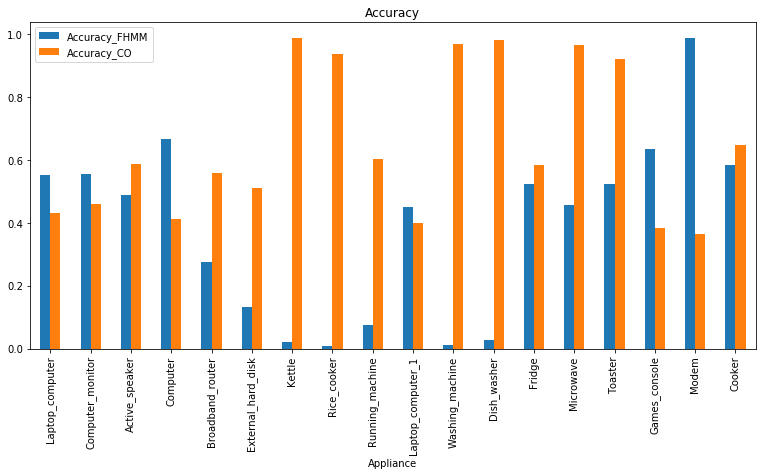

In [32]:
metric_df.plot(x="Appliance", y=["Accuracy_FHMM", "Accuracy_CO"], kind="bar", title='Accuracy')

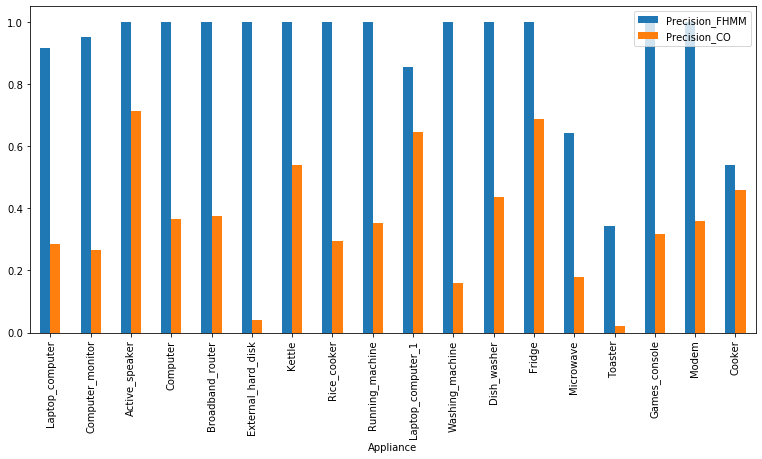

In [33]:
metric_df.plot(x="Appliance", y=["Precision_FHMM", "Precision_CO"], kind="bar")

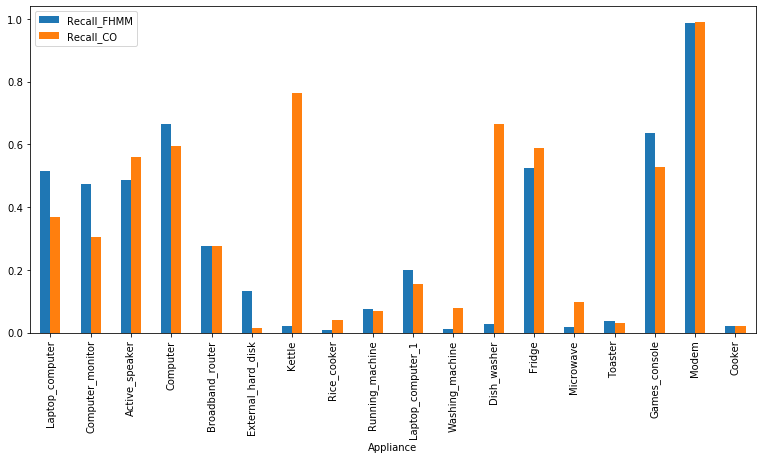

In [34]:
metric_df.plot(x="Appliance", y=["Recall_FHMM", "Recall_CO"], kind="bar")

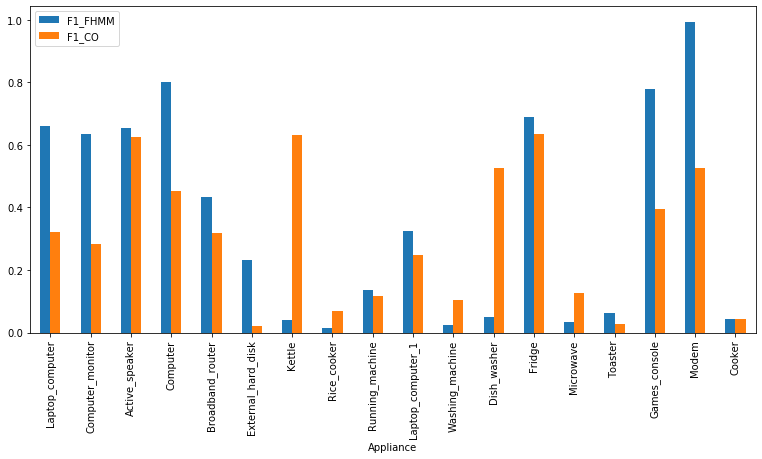

In [35]:
metric_df.plot(x="Appliance", y=["F1_FHMM", "F1_CO"], kind="bar")

In [36]:
co_predictions_csv_path = "./Predictions/Building_" + str(building_no) + "/predictions_CO.csv"
fhmm_predictions_csv_path = "./Predictions/Building_" + str(building_no) + "/predictions_FHMM.csv"
gt_csv_path = "./Predictions/Building_" + str(building_no) + "/ground_truth.csv"

modified_co_predictions_csv_path = "./Predictions/Building_" + str(building_no) + "/modified_predictions_CO.csv"
modified_fhmm_predictions_csv_path = "./Predictions/Building_" + str(building_no) + "/modified_predictions_FHMM.csv"
modified_gt_csv_path = "./Predictions/Building_" + str(building_no) + "/modified_ground_truth.csv"

In [37]:
with open(modified_fhmm_predictions_csv_path, 'w') as csvwfile:
    with open(fhmm_predictions_csv_path, newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        spamwriter = csv.writer(csvwfile, delimiter=',')
        for row in spamreader:
            row[0]=row[0].replace("+01:00","")
            spamwriter.writerow(row)
with open(modified_co_predictions_csv_path, 'w') as csvwfile:
    with open(co_predictions_csv_path, newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        spamwriter = csv.writer(csvwfile, delimiter=',')
        for row in spamreader:
            row[0]=row[0].replace("+01:00","")
            spamwriter.writerow(row)
with open(modified_gt_csv_path, 'w') as csvwfile:
    with open(gt_csv_path, newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        spamwriter = csv.writer(csvwfile, delimiter=',')
        for row in spamreader:
            row[0]=row[0].replace("+01:00","")
            spamwriter.writerow(row)

In [38]:
FHMM_df = pd.read_csv(modified_fhmm_predictions_csv_path, sep=',', parse_dates=['Date'], header=0, index_col="Date")
CO_df = pd.read_csv(modified_co_predictions_csv_path, sep=',', parse_dates=['Date'], header=0, index_col="Date")
GT_df = pd.read_csv(modified_gt_csv_path, sep=',', parse_dates=['Date'], header=0, index_col="Date")

In [39]:
nilmtk.utils.compute_rmse

<function nilmtk.utils.compute_rmse(ground_truth, predictions, pretty=True)>

In [40]:
rmse = {}
rmse["CO"] = nilmtk.utils.compute_rmse(GT_df, CO_df)
rmse_co = pd.DataFrame(rmse["CO"])
rmse["CO"] = nilmtk.utils.compute_rmse(GT_df, FHMM_df)
rmse_fhmm = pd.DataFrame(rmse["CO"])
merged_rmse_wo_normalization = rmse_co.merge(rmse_fhmm, left_index= True, right_index = True)
merged_rmse_wo_normalization.columns = ["rmse_co", "rmse_fhmm"]

In [41]:
merged_rmse_wo_normalization

,rmse_co,rmse_fhmm
Laptop computer,17.928162,373.532124
Computer monitor,44.272771,54.847787
Active speaker,5.553210,18.049691
Computer,11.086865,10.748089
Broadband router,9.778149,47.663476
External hard disk,7.370012,47.704777
Kettle,209.100807,280.816671
Rice cooker,65.202753,206.988295
Running machine,127.950259,25.016847
Laptop computer.1,18.768806,10.440585


In [42]:
x = CO_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
CO = pd.DataFrame(x_scaled)

x = FHMM_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
FHMM = pd.DataFrame(x_scaled)

x = GT_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
GT = pd.DataFrame(x_scaled)

In [43]:
CO.columns = CO_df.columns
FHMM.columns = FHMM_df.columns
GT.columns = GT_df.columns

In [44]:
rmse = {}
rmse["CO"] = nilmtk.utils.compute_rmse(GT, CO)
rmse_co = pd.DataFrame(rmse["CO"])
rmse["FHMM"] = nilmtk.utils.compute_rmse(GT,FHMM)
rmse_fhmm = pd.DataFrame(rmse["FHMM"])
merged_rmse_normalization = rmse_co.merge(rmse_fhmm, left_index= True, right_index = True)
merged_rmse_normalization.columns = ["rmse_co", "rmse_fhmm"]

In [45]:
merged_rmse_normalization

,rmse_co,rmse_fhmm
Laptop computer,0.577608,0.206004
Computer monitor,0.645575,0.599351
Active speaker,0.585425,0.533692
Computer,0.545925,0.615531
Broadband router,0.543927,0.759773
External hard disk,0.603194,0.262215
Kettle,0.076553,0.185985
Rice cooker,0.248279,0.668279
Running machine,0.611280,0.747884
Laptop computer.1,0.785064,0.696634


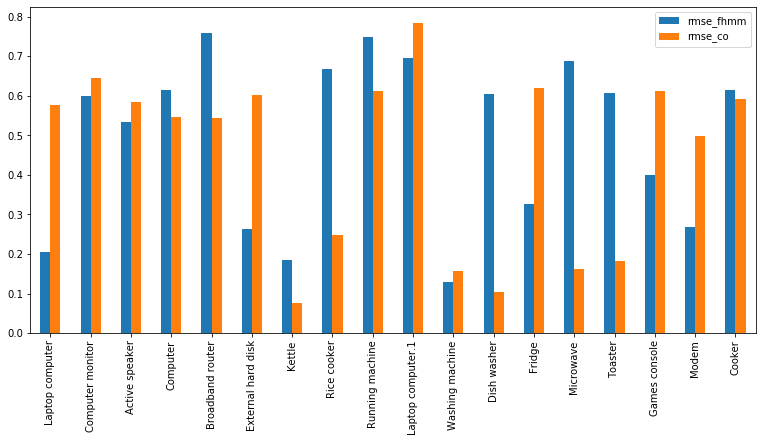

In [46]:
merged_rmse_normalization.plot(y=["rmse_fhmm","rmse_co"], kind="bar")

In [ ]:
# def to_timestamp(date):
#     return time.mktime(time.strptime(date, '%Y-%m-%d %H:%M:%S'))

In [ ]:
# FHMM_final = FHMM_df.reset_index()
# FHMM_final.Date=FHMM_final.apply(lambda row: to_timestamp(str(row.Date)), axis=1)
# FHMM_final=FHMM_final.set_index('Date')

In [ ]:
# channel_number =2
# labels = ["Aggregate"]
# idx = [1]
# for column in FHMM_final.columns:
#     FHMM_final[column].to_csv("Building2/channel_"+str(channel_number)+".dat",sep=' ', header=False)
#     labels.append(str(column))
#     idx.append(channel_number)
#     channel_number += 1 

In [ ]:
# labels_df= pd.DataFrame(labels, index=idx) 

In [ ]:
# labels_df

In [ ]:
# labels_df.to_csv("Building2/labels.dat",sep=' ', header=False)